#**Eισαγωγή για τα δεδομένα**
###Έχουμε 184 βίντεο από ασθενείς με οστεοαρθρίτιδα γονάτου και υγιή άτομα .Τα οποία έχουν καταγραφεί από κάμερα 50fps HD :

*   PD  -->  12 με νόσο Parkinson
*   KOA --> 50 Ασθενείς με οστεοαθρίτιδα
*   NM  --> 30 Yγειή άτομα  

### 2 Βίντεο για κάθε άτομο ,όπου το καθένα είναι από διαφορετική  πλευρά κατγραφής.Τα οποία συγχωνεύτηκαν προσθέτοντας ένα χαρακτηριστικό για να υποδηλώσουμε την πλευρά.

###Τα σημεία που χρησιμοποιήθηκαν είναι:

*   Κεφάλι
*   Δεξιός και αριστερός καρπός
*   Δεξιός και αριστερός αγκώνας
*   Δεξιός και Αριστερός ώμος
*   Δεξιό και Αριστερό γόνατο
*   Δεξιός και Αριστερός αστράγαλος
*   Δεξιός και Αριστερός  γοφός

##**Σύνδεση με το drive και τα αρχεία των αντικειμένων.**



In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/' .
train_data_paths = '/content/drive/MyDrive/project/concat_out_scaler_v1'

t="/content/drive/MyDrive/project/concat_out_scaler_v3/scaler_028_NM.csv"
df = pd.read_csv(t)
print(df.head)

Mounted at /content/drive
cp: -r not specified; omitting directory '/content/drive/MyDrive/'
<bound method NDFrame.head of      Side  LEFT_SHOULDER_x  LEFT_SHOULDER_y  LEFT_SHOULDER_z  \
0       1        -1.745613        -1.273866        -0.481427   
1       1        -1.687485        -1.267877        -1.344524   
2       1        -1.613538        -1.023717        -1.313738   
3       1        -1.559821        -0.953978        -1.130251   
4       1        -1.537335        -0.965785        -0.522987   
..    ...              ...              ...              ...   
176     2        -1.454477         1.552848         1.841937   
177     2        -1.458438         1.372911         1.208618   
178     2        -1.436572        -1.632315         1.052802   
179     2        -1.459653        -1.648958         0.660021   
180     2        -1.447042        -1.851195         1.462872   

     LEFT_SHOULDER_visibility  RIGHT_SHOULDER_x  RIGHT_SHOULDER_y  \
0                    0.999263         -

##**Μοντέλο RESNET-LSTM με  resnet μίας διάστασης.**
###Το NeurologicalDiseaseModel συνδυάζει ResNet, Squeeze-and-Excitation (SE) Block και LSTM για ανάλυση σειριακών δεδομένων. Αρχικά, το ResNet Block εξάγει χαρακτηριστικά με skip connections για αποδοτικότερη μάθηση, ενώ το SE Block προσαρμόζει δυναμικά τη σημασία κάθε καναλιού μέσω attention. Στη συνέχεια, ένα διεπίπεδο LSTM μαθαίνει τις χρονικές εξαρτήσεις των δεδομένων και περνάει την τελική αναπαράσταση σε ένα fully connected layer για ταξινόμηση. Με dropout (p=0.6) για regularization, η αρχιτεκτονική είναι κατάλληλη για αναγνώριση προτύπων σε βιοϊατρικά σήματα ή αισθητήρες
##**Για την παραπάνω Αρχιτεκτονική βασίστηκα στο παράκατω Αρθρό:**
** https://www.sciencedirect.com/science/article/pii/S0010482524003986**

###Το άρθρο "Automatic sleep staging by a hybrid model based on deep 1D-ResNet-SE and LSTM with single-channel raw EEG signals" παρουσιάζει ένα υβριδικό μοντέλο που συνδυάζει ένα μονοδιάστατο Residual Network με Squeeze-and-Excitation (1D-ResNet-SE) και ένα Long Short-Term Memory (LSTM) δίκτυο για την αυτόματη ταξινόμηση των σταδίων ύπνου χρησιμοποιώντας μονοκαναλικά ακατέργαστα σήματα EEG. Το μοντέλο αξιοποιεί τα ResNet blocks για την εξαγωγή χαρακτηριστικών, τα SE blocks για την ενίσχυση των σημαντικών καναλιών και το LSTM για την κατανόηση των χρονικών εξαρτήσεων στα δεδομένα. Ο κώδικας του μοντέλου είναι διαθέσιμος στο GitHub https://github.com/weiming1122/1D-ResNet-SE-LSTM/blob/main/model_resnet_se_lstm.py , ο οποίος τροποποιήθηκε  με βάση τα δεδομένα μου και τις ανάγκες της ταξινόμησης για τις δύο κλάσεις.

###**Παρά το ότι το παραπάνω αρθρό  ασχολείται με σήματα και τα δεδομένα μας έχουν την μορφή συντεταγμένων , είναι ιδιαίτερα χρήσιμό ,καθώς τα δεδομένα μου θέλουν να αναλύονται με την μορφή μονοδιαστάτων καναλίων.**



In [2]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch

""" https://www.sciencedirect.com/science/article/pii/S0010482524003986
    https://github.com/weiming1122/1D-ResNet-SE-LSTM/blob/main/model_resnet_se_lstm.py
    """

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)

        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.relu = nn.ReLU()

    def forward(self, x):
        # Δημιουργία shortcut ωστέ να μεταδοθει η αρχική πληροφορία στα επόμενα
        residual = self.shortcut(x)

        #Πρώτο επιπέδο cnn επιπεδό
        x = self.conv1(x)
        x = self.relu(x)
        x = x + residual

        residual2 = x # Δημιουργία shortcut ωστέ να μεταδοθει η αρχική πληροφορία στα επόμενα

        #Δεύτερο επίπεδο cnn με residual
        x = self.conv2(x)
        x = self.relu(x)
        x = x + residual + residual2
        return x

class SEBlock(nn.Module):
  #Squeeze-and-Excitation Block
  # https://arxiv.org/abs/1709.01507
    def __init__(self, in_channels):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // 8)
        self.fc2 = nn.Linear(in_channels // 8, in_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
       # Squeeze (Συμπίεση):Χρησιμοποιεί τη συνάρτηση torch.mean(x, dim=2) για να υπολογίσει τον μέσο όρο κάθε καναλιού (channel) πάνω από
       #τις χωρικές διαστάσεις (height και width). Αυτό δίνει ένα διάνυσμα με διαστάσεις (batch_size, in_channels) που αντιπροσωπεύει την
       #"συμπυκνωμένη" πληροφορία για κάθε κανάλι.
        y = torch.mean(x, dim=2)
       #Excitation
       #Το πρώτο επίπεδο (self.fc1) μειώνει τη διάσταση των καναλιών από in_channels σε in_channels // 8
       # (δηλαδή, διαιρεί τον αριθμό των καναλιών δια 8).
        y = self.relu(self.fc1(y))
        # το δεύτερο επίπεδο (self.fc2) αυξάνει ξανά τη διάσταση των καναλιών από in_channels // 8 πίσω σε in_channels.
        y = self.fc2(y).unsqueeze(2)
        #Το διάνυσμα των βαρών επανασχηματίζεται σε διαστάσεις (batch_size, in_channels, 1, 1) χρησιμοποιώντας την unsqueeze(2).

        # η αρχική είσοδος x πολλαπλασιάζεται με αυτά τα βάρη (x * y),
        #δίνοντας περισσότερη βαρύτητα στα πιο σημαντικά κανάλια και λιγότερη στα λιγότερο
        # σημαντικά.
        return x * y

class NeurologicalDiseaseModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(NeurologicalDiseaseModel, self).__init__()
        self.resnet = ResNetBlock(input_channels, 64)  # ResNet Block
        self.se = SEBlock(64)  # Squeeze-and-Excitation Block
        self.lstm = nn.LSTM(64, 128, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(p=0.6)  # Dropout μετά το LSTM
        self.fc = nn.Linear(128, num_classes)  # Output Layer για num_classes κλάσεις

    def forward(self, x):# x = [16,50,3,13]
        x = x.view(x.size(0), -1, x.size(1))  # Flatten the (3, 13) -> 39 features
        x = self.resnet(x)
        x = self.se(x)
        x = self.dropout(x)
        x, _ = self.lstm(x.transpose(1, 2))  # LSTM περιμένει (batch, seq, features)
        x = x[:, -1, :]  # Μόνο η τελευταία έξοδος
        x = self.fc(x)  # Τελική ταξινόμηση
        return x

###**Δημιουργία κλασής Dataset για φερνει τα δεδομένα με την μορφη batch size ,sequence length,channel ,features.**

####Η κλάση CustomCSVData είναι ένα dataset για την επεξεργασία χρονικών σειρών από αρχεία CSV, που περιέχουν τρισδιάστατες συντεταγμένες (x, y, z) συγκεκριμένων σημείων του σώματος (π.χ., ώμοι, ισχία, αστράγαλοι, κεφάλι). Υποστηρίζει τόσο μεμονωμένα αρχεία όσο και φακέλους με πολλά CSV. Αρχικά, φορτώνει τα δεδομένα, επιλέγει τις απαραίτητες στήλες και τα οργανώνει σε μορφή (samples, 3, 13), όπου κάθε δείγμα περιλαμβάνει τις συντεταγμένες xyz των εννέα σημείων του σώματος. Τα δεδομένα χωρίζονται σε παράθυρα σταθερού μήκους (sequence_length), ώστε να διατηρούνται οι χρονικές εξαρτήσεις, ενώ τα αντίστοιχα labels αντιστοιχούν στο τελευταίο frame κάθε παραθύρου.Τέλος εφαρμόζεται  oversampling κατά τον χωρισμό των δεδομένων σε χρονικά παραθυρα για την ισορροπία των κλάσεων (αν υπάρχει ανισορροπία στις ετικέτες).

####Αυτή η προσέγγιση επιλέχθηκε γιατί επιτρέπει τη χρήση του dataset σε νευρωνικά δίκτυα όπως το ResNet-SE-LSTM, που απαιτούν δομημένη χρονική είσοδο. Η μέθοδος sliding windows διασφαλίζει ότι το δίκτυο λαμβάνει αλληλουχίες δεδομένων αντί για μεμονωμένα στιγμιότυπα, βελτιώνοντας την εκμάθηση κινητικών προτύπων. Επιπλέον, η μετατροπή των δεδομένων σε torch.Tensor τα καθιστά έτοιμα για χρήση σε PyTorch models, διευκολύνοντας την εκπαίδευση ενός συστήματος που μπορεί να ανιχνεύει ανωμαλίες κίνησης ή να κατηγοριοποιεί κινητικές συμπεριφορές.

In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import chardet
from collections import defaultdict
from sklearn.utils import resample

class CustomCSVData(Dataset):
    def __init__(self, file_paths, target, sequence_length=50, strict_mode=False, num_rows=None):
        self.data = []
        self.labels = []
        self.sequence_length = sequence_length  # Το μήκος κάθε ακολουθίας (παράθυρο)
        self.strict_mode = strict_mode  # Ενεργοποίηση αυστηρού τρόπου για σφάλματα
        self.target = target  # Η στήλη στόχος (label)
        self.num_rows = num_rows  # Αριθμός γραμμών για ανάγνωση από το αρχείο (προαιρετικό)

        # Ορισμός των σημείων του σώματος και των στηλών xyz για κάθε σημείο
        self.body_parts = ["LEFT_SHOULDER", "RIGHT_SHOULDER", "LEFT_HIP", "RIGHT_HIP",
                           "LEFT_ANKLE", "RIGHT_ANKLE", "LEFT_ELBOW", "RIGHT_ELBOW",
                           "LEFT_WRIST", "RIGHT_WRIST", "LEFT_KNEE", "RIGHT_KNEE", "HEAD"]
        self.xyz_columns = [[f"{part}_{axis}" for axis in "xyz"] for part in self.body_parts]

        # Λήψη όλων των αρχείων CSV από τα δεδομένα
        self.file_paths = self._get_csv_files(file_paths)
        self._process_files()  # Επεξεργασία των δεδομένων από τα αρχεία

    def _get_csv_files(self, file_paths):
        all_files = []
        for path in file_paths:
            if os.path.isdir(path):
                # Εάν είναι φάκελος, αναζητούμε όλα τα αρχεία CSV μέσα σε αυτόν
                all_files.extend([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')])
                print(f"Βρέθηκαν {len(all_files)} αρχεία CSV στο φάκελο {path}")
            elif os.path.isfile(path) and path.endswith('.csv'):
                # Εάν είναι αρχείο, το προσθέτουμε στη λίστα
                all_files.append(path)
        return all_files

    def _process_files(self):
        all_windows = []  # Αποθήκευση όλων των παραθύρων
        all_labels = []   # Αποθήκευση όλων των ετικετών

        for file_path in self.file_paths:
            try:
                # Αυτόματος έλεγχος κωδικοποίησης για το αρχείο
                with open(file_path, 'rb') as f:
                    result = chardet.detect(f.read())
                    encoding = result['encoding']

                # Ανάγνωση του αρχείου CSV
                df = pd.read_csv(file_path, nrows=self.num_rows, encoding=encoding, on_bad_lines='skip')

                if df.empty:
                    print(f"Το αρχείο {file_path} είναι κενό ή δεν διαβάστηκε σωστά.")
                    continue

                # Καθαρισμός και επεξεργασία των δεδομένων
                df = self._clean_and_process_data(df, file_path)

                # Ομαδοποίηση των δεδομένων ανά 'Id' και 'Side'
                grouped = df.groupby(['Id', 'Side'])  # Υποθέτουμε ότι υπάρχουν στήλες 'Id' και 'Side'
                for (id_val, side_val), group in grouped:
                    features, labels = self._process_patient_data(group)

                    # Δημιουργία sliding windows αν το μέγεθος του παραθύρου είναι επαρκές
                    if len(features) >= self.sequence_length:
                        for i in range(len(features) - self.sequence_length + 1):
                            all_windows.append(features[i:i + self.sequence_length])
                            all_labels.append(labels[i + self.sequence_length - 1])
                    else:
                        print(f"Δεν υπάρχουν αρκετά δείγματα για την ομάδα (id={id_val}, side={side_val}) με μήκος παραθύρου {self.sequence_length}.")

            except Exception as e:
                if self.strict_mode:
                    raise
                else:
                    print(f"Σφάλμα κατά την επεξεργασία του αρχείου {file_path}: {e}")

        # Oversampling των παραθύρων
        self.data, self.labels = self._oversample_windows(all_windows, all_labels)

    def _clean_and_process_data(self, df, file_path):
        # Διαγραφή γραμμών με NaN στην στήλη στόχου (target)
        df = df.dropna(subset=[self.target])
        df.ffill(inplace=True)  # Εφαρμογή forward fill για τις υπόλοιπες στήλες με NaN
        return df

    def _process_patient_data(self, df):
        xyz_data = []

        # Έλεγχος αν όλες οι στήλες xyz υπάρχουν στο DataFrame
        for part_columns in self.xyz_columns:
            if not all(col in df.columns for col in part_columns):
                raise ValueError(f"Λείπουν οι αναμενόμενες στήλες XYZ στο dataframe: {part_columns}")
            xyz_data.append(df[part_columns].values)

        # Σχηματισμός δεδομένων σε μορφή (samples, 3 (x,y,z), 13 σημεία σώματος)
        features = np.stack(xyz_data, axis=-1).transpose(0, 2, 1)
        labels = df[self.target].values  # Στόχος (labels)

        return features, labels

    def _oversample_windows(self, windows, labels):
        # Ομαδοποίηση παραθύρων ανά ετικέτα
        label_to_windows = defaultdict(list)
        for window, label in zip(windows, labels):
            label_to_windows[label].append(window)

        # Εύρεση του μέγιστου αριθμού παραθύρων ανά κλάση
        max_windows = max(len(windows) for windows in label_to_windows.values())

        # Oversampling για κάθε κλάση (παραθυράκια)
        oversampled_windows = []
        oversampled_labels = []
        for label, windows in label_to_windows.items():
            if len(windows) < max_windows:
                # Επαναλαμβάνουμε τα παράθυρα της μειοψηφικής κλάσης
                oversampled = resample(windows, replace=True, n_samples=max_windows, random_state=42)
                oversampled_windows.extend(oversampled)
                oversampled_labels.extend([label] * max_windows)
            else:
                oversampled_windows.extend(windows)
                oversampled_labels.extend([label] * len(windows))

        # Εφαρμογή Undersampling για την υπερεκπροσωπούμενη κλάση
        min_windows = min(len(windows) for windows in label_to_windows.values())
        undersampled_windows = []
        undersampled_labels = []
        for label, windows in label_to_windows.items():
            if len(windows) > min_windows:
                # Επιλογή τυχαίων παραθύρων για την υπερεκπροσωπούμενη κλάση
                undersampled = resample(windows, replace=False, n_samples=min_windows, random_state=42)
                undersampled_windows.extend(undersampled)
                undersampled_labels.extend([label] * min_windows)
            else:
                undersampled_windows.extend(windows)
                undersampled_labels.extend([label] * len(windows))

        # Συνδυασμός oversampling και undersampling
        balanced_windows = oversampled_windows + undersampled_windows
        balanced_labels = oversampled_labels + undersampled_labels

        return balanced_windows, balanced_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Επιστροφή του δείγματος και της ετικέτας ως tensor
        data_tensor = torch.tensor(self.data[idx], dtype=torch.float32)  # (sequence_length, 13, 3)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.int64)  # Μοναδική τιμή για τον στόχο
        return data_tensor, label_tensor


#**Εκπαίδευση μοντέλου με Leave One sybject out  cross validation**

In [4]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, roc_auc_score,roc_curve
from torch.utils.data import DataLoader




# Συνάρτηση για την καταμέτρηση αρχείων CSV σε ένα φάκελο
def count_csv_files(folder_path):
    """
    Μετράει τα αρχεία CSV σε έναν φάκελο.

    Parameters:
    - folder_path (str): Διαδρομή προς το φάκελο.

    Returns:
    - int: Αριθμός αρχείων CSV στο φάκελο.
    """
    if not os.path.isdir(folder_path):  # Έλεγχος αν η διαδρομή είναι φάκελος
        raise ValueError(f"{folder_path} is not a valid directory.")

    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]  # Φιλτράρισμα μόνο αρχείων CSV
    return len(csv_files)  # Επιστροφή του πλήθους των αρχείων

# Συνάρτηση για καταμέτρηση γραμμών σε ένα αρχείο CSV
def count_line_csv(s):
    with open(s, "r") as file:  # Άνοιγμα του αρχείου σε λειτουργία ανάγνωσης
        reader = csv.reader(file)
        n = sum(1 for row in reader) - 1  # Υπολογισμός των γραμμών, αφαιρώντας τη γραμμή κεφαλίδας
    return n




#**Η συνάρτηση loso_cross_validation**
###Η συνάρτηση loso_cross_validation εφαρμόζει τη διαδικασία Leave-One-Subject-Out (LOSO) Cross-Validation για την εκπαίδευση και αξιολόγηση ενός νευρωνικού δικτύου σε δεδομένα πολλών συμμετεχόντων. Σε κάθε επανάληψη, ένας συμμετέχοντας αφαιρείται από το σύνολο εκπαίδευσης και χρησιμοποιείται ως σύνολο επικύρωσης (validation set), ενώ τα υπόλοιπα δεδομένα χρησιμοποιούνται για την εκπαίδευση του μοντέλου. Το νευρωνικό δίκτυο εκπαιδεύεται με τον Adam optimizer και ως συνάρτηση απώλειας (loss function) χρησιμοποιείται η CrossEntropyLoss, καθώς οι ετικέτες (labels) των δεδομένων είναι ακέραιοι αριθμοί (0,1,2) αντί για one-hot encoded διανύσματα. Κατά τη διάρκεια της εκπαίδευσης, υπολογίζονται μετρικές όπως η ακρίβεια, η F1-score, η precision και η recall τόσο για το training όσο και για το validation set.

###Μετά από κάθε iteration, αν η ακρίβεια στο validation set είναι η υψηλότερη που έχει επιτευχθεί μέχρι στιγμής και η απώλεια είναι η χαμηλότερη, το καλύτερο μοντέλο αποθηκεύεται. Στο τέλος της διαδικασίας, υπολογίζονται οι μέσες τιμές όλων των μετρικών, προσφέροντας μια συνολική εικόνα της απόδοσης του μοντέλου.

##Υπερπαραμέτροι :

*    batch size: 16
*    learning rate : 0.0001
*    L2 regurlarization : weight decay 0.0001
*    Optimizer Adam
*    Dropout : 0.6

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score
from torch.utils.data import DataLoader
from collections import Counter
from torchvision import models
from sklearn.preprocessing import label_binarize

def loso_cross_validation(train_data_folder,valid_data_folder, device, target="disease", num_classes=3, seq_len=50, batch_size=16, learning_rate=0.0001, num_epochs=1):
    train_csv_files = [f for f in os.listdir(train_data_folder) if f.endswith('.csv')]
    train_num_subjects = len(train_csv_files)

    valid_csv_files = [f for f in os.listdir(valid_data_folder) if f.endswith('.csv')]
    valid_num_subjects = len(valid_csv_files)

    train_losses, val_losses = [], []
    val_accuracies, train_accuracies = [], []
    train_f1_scores, train_precisions, train_recalls = [], [], []
    val_f1 =[]


    random.shuffle(train_csv_files)
    #random.shuffle(valid_csv_files)

    for i in range(valid_num_subjects):
        print(f"LOSO CV subject {i+1}/{valid_num_subjects}: Leaving out subject {valid_csv_files[i]}")

        val_file = os.path.join(valid_data_folder, valid_csv_files[i])
        train_files = [os.path.join(train_data_folder, f) for f in train_csv_files if f != valid_csv_files[i]]

        random.shuffle(train_files)

        model =NeurologicalDiseaseModel(39, num_classes)
        model = model.to(device)

        train_dataset = CustomCSVData(file_paths=train_files, target=target)
        val_dataset = CustomCSVData(file_paths=[val_file], target=target)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()

        subject_results = []

        for epoch in range(num_epochs):
            train_loader = DataLoader(train_dataset, batch_size=True, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=True, shuffle=False)

            model.train()
            train_loss = 0.0
            all_train_preds, all_train_labels = [], []

            for features, labels in train_loader:
                features, labels = features.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_train_preds.extend(preds.cpu().numpy())
                all_train_labels.extend(labels.cpu().numpy())

            train_loss_avg = train_loss / len(train_loader)
            train_losses.append(train_loss_avg)

            train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
            train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
            train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
            train_accuracy = accuracy_score(all_train_labels, all_train_preds)

            train_accuracies.append(train_accuracy)
            train_f1_scores.append(train_f1)
            train_precisions.append(train_precision)
            train_recalls.append(train_recall)

        model.eval()
        all_val_preds, all_val_labels = [], []
        all_val_probs = []
        val_loss = 0.0

        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                all_val_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())


        val_loss_avg = val_loss / len(val_loader)
        val_losses.append(val_loss_avg)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_accuracies.append(val_accuracy)

        #f1 = f1_score(all_val_labels, all_val_preds, average="binary", pos_label=all_val_labels[1])
        f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_f1.append(f1)
        result_dict = {
    "Subject": valid_csv_files[i],
    "Target": all_val_labels[1],
    "Test Loss": val_loss_avg,
    "Test Accuracy": val_accuracy,
    "Test F1 score": f1

       }
        predicted_class_counts = dict(Counter(all_val_preds))
        for class_id in range(num_classes):
             result_dict[f"Predicted class {class_id}"] = predicted_class_counts.get(class_id, 0)

        subject_results.append(result_dict)

        import pandas as pd

        results_file = '/content/drive/MyDrive/project/loso_subject_lstm_levels_results.csv'

        # Δημιουργία DataFrame από τα αποτελέσματα
        df = pd.DataFrame(subject_results)

          # Έλεγχος αν υπάρχει το αρχείο
        file_exists = os.path.isfile(results_file)


        if file_exists:
            try:
              existing_df = pd.read_csv(results_file)
              combined_df = pd.concat([existing_df, df], ignore_index=True)
              combined_df.drop_duplicates(inplace=True)
              combined_df.to_csv(results_file, index=False, float_format='%.4f')
            except pd.errors.EmptyDataError:  # Handle the EmptyDataError if it occurs
               print("Warning: 'loso_subject_results.csv' is empty or corrupted. Creating a new file.")
               df.to_csv(results_file, index=False, float_format='%.4f')
        else:
           df.to_csv(results_file, index=False, float_format='%.4f')


        print(f"Iteration {i+1}:")
        print(f"  Test Loss: {val_loss_avg:.4f}")
        print(f"  Test Accuracy: {val_accuracy:.4f}")
        print(f"  Test F1 Score: {f1:.4f}")
        print(f"  Test Predictions Distribution:", Counter(all_val_preds))

    print("\n=== Final Metrics ===")
    print(f"Avg Train Accuracy: {np.nanmean(train_accuracies):.4f}")
    print(f"Avg Train F1 Score: {np.nanmean(train_f1_scores):.4f}")
    print(f"Avg Train Precision: {np.nanmean(train_precisions):.4f}")
    print(f"Avg Train Recall: {np.nanmean(train_recalls):.4f}")
    print(f"Avg Test Accuracy: {np.nanmean(val_accuracies):.4f}")
    print(f"Avg Test F1 Score: {np.nanmean(val_f1):.4f}")

    print(f"Standard Deviation Train Accuracy: {np.nanstd(train_accuracies):.4f}")
    print(f"Standard Deviation Train F1 Score: {np.nanstd(train_f1_scores):.4f}")
    print(f"Standard Deviation Train Precision: {np.nanstd(train_precisions):.4f}")
    print(f"Standard Deviation Train Recall: {np.nanstd(train_recalls):.4f}")
    print(f"Standard Deviation Test Accuracy: {np.nanstd(val_accuracies):.4f}")
    print(f"Standard Deviation Test F1 Score: {np.nanstd(val_f1):.4f}")




    return  0


#**Αποτελέσματα .......**

In [ ]:


if __name__ == "__main__":
    # Ορισμός διαδρομών προς τα datasets
    train_data_paths = '/content/drive/MyDrive/project/train'
    valid_data_paths ='/content/drive/MyDrive/project/concat_out_scaler_v1'


    # Καταμέτρηση αρχείων CSV στον φάκελο εκπαίδευσης
    train_count = count_csv_files(train_data_paths)

    # Ορισμός της συσκευής (CPU ή GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    model=loso_cross_validation(train_data_paths,valid_data_paths,device)

LOSO CV subject 1/31: Leaving out subject scaler_006PD_MD.csv
Iteration 1:
  Test Loss: 1.1540
  Test Accuracy: 0.1322
  Test F1 Score: 0.2336
  Test Predictions Distribution: Counter({np.int64(1): 934, np.int64(2): 146, np.int64(0): 24})
LOSO CV subject 2/31: Leaving out subject scaler_006PD_ML.csv
Iteration 2:
  Test Loss: 0.9286
  Test Accuracy: 0.4431
  Test F1 Score: 0.6141
  Test Predictions Distribution: Counter({np.int64(1): 910, np.int64(2): 724})
LOSO CV subject 3/31: Leaving out subject scaler_013KOA_EL.csv
Iteration 3:
  Test Loss: 0.6142
  Test Accuracy: 0.6938
  Test F1 Score: 0.8192
  Test Predictions Distribution: Counter({np.int64(1): 648, np.int64(2): 286})
LOSO CV subject 4/31: Leaving out subject scaler_011KOA_EL.csv
Iteration 4:
  Test Loss: 0.8809
  Test Accuracy: 0.5837
  Test F1 Score: 0.7371
  Test Predictions Distribution: Counter({np.int64(1): 830, np.int64(2): 490, np.int64(0): 102})
LOSO CV subject 5/31: Leaving out subject scaler_006KOA_EL.csv
Iteration 5:

In [ ]:

if __name__ == "__main__":
    # Ορισμός διαδρομών προς τα datasets
    train_data_paths = '/content/drive/MyDrive/project/train'
    valid_data_paths ='/content/drive/MyDrive/project/concat_out_scaler_v2'

    # Καταμέτρηση αρχείων CSV στον φάκελο εκπαίδευσης
    train_count = count_csv_files(train_data_paths)

    # Ορισμός της συσκευής (CPU ή GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    model=loso_cross_validation(train_data_paths,valid_data_paths,device)

LOSO CV subject 1/30: Leaving out subject scaler_004PD_MD.csv
Iteration 1:
  Test Loss: 0.6795
  Test Accuracy: 0.7258
  Test F1 Score: 0.8411
  Test Predictions Distribution: Counter({np.int64(2): 884, np.int64(1): 276, np.int64(0): 58})
LOSO CV subject 2/30: Leaving out subject scaler_001PD_SV.csv
Iteration 2:
  Test Loss: 0.7091
  Test Accuracy: 0.5529
  Test F1 Score: 0.7120
  Test Predictions Distribution: Counter({np.int64(2): 1956, np.int64(1): 1556, np.int64(0): 26})
LOSO CV subject 3/30: Leaving out subject scaler_001PD_MD.csv
Iteration 3:
  Test Loss: 0.8227
  Test Accuracy: 0.6954
  Test F1 Score: 0.8204
  Test Predictions Distribution: Counter({np.int64(2): 1096, np.int64(1): 358, np.int64(0): 122})
LOSO CV subject 4/30: Leaving out subject scaler_003PD_MD.csv
Iteration 4:
  Test Loss: 1.2902
  Test Accuracy: 0.1512
  Test F1 Score: 0.2627
  Test Predictions Distribution: Counter({np.int64(1): 808, np.int64(2): 150, np.int64(0): 34})
LOSO CV subject 5/30: Leaving out subjec

In [ ]:

if __name__ == "__main__":
    # Ορισμός διαδρομών προς τα datasets
    train_data_paths = '/content/drive/MyDrive/project/train'
    valid_data_paths ='/content/drive/MyDrive/project/concat_out_scaler_v3'

    # Καταμέτρηση αρχείων CSV στον φάκελο εκπαίδευσης
    train_count = count_csv_files(train_data_paths)

    # Ορισμός της συσκευής (CPU ή GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    model=loso_cross_validation(train_data_paths,valid_data_paths,device)

LOSO CV subject 1/30: Leaving out subject scaler_005PD_ML.csv
Iteration 1:
  Test Loss: 1.1288
  Test Accuracy: 0.2116
  Test F1 Score: 0.3493
  Test Predictions Distribution: Counter({np.int64(1): 1396, np.int64(2): 380, np.int64(0): 20})
LOSO CV subject 2/30: Leaving out subject scaler_007PD_MD.csv
Iteration 2:
  Test Loss: 1.1016
  Test Accuracy: 0.3221
  Test F1 Score: 0.4873
  Test Predictions Distribution: Counter({np.int64(1): 1226, np.int64(2): 594, np.int64(0): 24})
LOSO CV subject 3/30: Leaving out subject scaler_015KOA_EL.csv
Iteration 3:
  Test Loss: 0.5073
  Test Accuracy: 0.8854
  Test F1 Score: 0.9392
  Test Predictions Distribution: Counter({np.int64(1): 958, np.int64(2): 74, np.int64(0): 50})
LOSO CV subject 4/30: Leaving out subject scaler_008KOA_EL.csv
Iteration 4:
  Test Loss: 0.8518
  Test Accuracy: 0.7163
  Test F1 Score: 0.8347
  Test Predictions Distribution: Counter({np.int64(1): 596, np.int64(0): 126, np.int64(2): 110})
LOSO CV subject 5/30: Leaving out subjec

-----
## Επεξεργασία Αποτελεσμάτων

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Διαβάζουμε το csv
df = pd.read_csv("/content/drive/MyDrive/project/loso_subject_lstm_results_.csv")

# 2. Υπολογισμός μέσου όρου και τυπικής απόκλισης για συγκεκριμένες στήλες
metrics = [ 'Test Accuracy', 'Test F1 score']
avg_std = df[metrics].agg(['mean', 'std'])

print("Μέσοι όροι και Τυπικές αποκλίσεις:")
print(avg_std)

# 3. Υπολογισμός precision, recall, f1_macro, f1_micro με βάση τις προβλέψεις
classes = [0, 1, 2]
results = {}

# Αρχικοποίηση πίνακα για αθροιστικά αποτελέσματα για micro-averaging
micro_tp = 0
micro_fp = 0
micro_fn = 0
micro_tn = 0

for cls in classes:
    tp = df.loc[df['Target'] == cls, f'Predicted class {cls}'].sum()
    fp = df.loc[df['Target'] != cls, f'Predicted class {cls}'].sum()

    # FN = άθροισμα προβλέψεων σε λάθος κλάσεις όταν η αλήθεια είναι cls
    fn = df.loc[df['Target'] == cls, [f'Predicted class {c}' for c in classes if c != cls]].sum().sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    results[cls] = {
        'TP': tp, 'FP': fp, 'FN': fn,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    # Ενημέρωση αθροιστικών μετρικών για micro averaging
    micro_tp += tp
    micro_fp += fp
    micro_fn += fn

# 4. Εκτύπωση αποτελεσμάτων ανά κλάση
for cls, metrics in results.items():
    print(f"\nΚλάση {cls}:")
    for key, val in metrics.items():
        print(f"  {key}: {val:.4f}" if isinstance(val, float) else f"  {key}: {val}")

# 5. Υπολογισμός του Macro F1
macro_f1 = sum(r['F1 Score'] for r in results.values()) / len(classes)

# 6. Υπολογισμός του Micro Precision, Recall και F1
micro_precision = micro_tp / (micro_tp + micro_fp) if (micro_tp + micro_fp) > 0 else 0
micro_recall = micro_tp / (micro_tp + micro_fn) if (micro_tp + micro_fn) > 0 else 0
micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

# 7. Υπολογισμός του Macro Precision και Recall
macro_precision = sum(r['Precision'] for r in results.values()) / len(classes)
macro_recall = sum(r['Recall'] for r in results.values()) / len(classes)

# 8. Εκτύπωση Macro & Micro metrics
print("\n--- Macro & Micro Metrics ---")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall   : {macro_recall:.4f}")
print(f"Macro F1 Score : {macro_f1:.4f}")
print(f"Micro Precision: {micro_precision:.4f}")
print(f"Micro Recall   : {micro_recall:.4f}")
print(f"Micro F1 Score : {micro_f1:.4f}")


Μέσοι όροι και Τυπικές αποκλίσεις:
      Test Accuracy  Test F1 score
mean       0.692519       0.787289
std        0.255001       0.212361

Κλάση 0:
  TP: 7742
  FP: 5004
  FN: 1732
  Precision: 0.6074
  Recall: 0.8172
  F1 Score: 0.6968

Κλάση 1:
  TP: 43460
  FP: 12648
  FN: 25290
  Precision: 0.7746
  Recall: 0.6321
  F1 Score: 0.6962

Κλάση 2:
  TP: 11480
  FP: 21374
  FN: 12004
  Precision: 0.3494
  Recall: 0.4888
  F1 Score: 0.4075

--- Macro & Micro Metrics ---
Macro Precision: 0.5771
Macro Recall   : 0.6461
Macro F1 Score : 0.6002
Micro Precision: 0.6163
Micro Recall   : 0.6163
Micro F1 Score : 0.6163




 __________________________________________________

 # Εκτελέση Πειράματος με αύξηση ετικετών .
 ##### Προσθήκη  Severity για τα άτομα με Οστεοαθρίτιδα γονάτου.

In [ ]:
if __name__ == "__main__":
    # Ορισμός διαδρομών προς τα datasets
    train_data_paths = '/content/drive/MyDrive/project/train'
    valid_data_paths ='/content/drive/MyDrive/project/concat_out_scaler_v3'


    # Καταμέτρηση αρχείων CSV στον φάκελο εκπαίδευσης
    train_count = count_csv_files(train_data_paths)

    # Ορισμός της συσκευής (CPU ή GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_channels=3
    num_classes=5
    print("Initializing model...")
    model = NeurologicalDiseaseModel(input_channels, num_classes)  # Ορισμός του μοντέλου
    model.to(device)  # Μεταφορά του μοντέλου στη συσκευή

    model=loso_cross_validation(train_data_paths,valid_data_paths,device,target="Disease_Level",num_classes=num_classes)

Initializing model...
LOSO CV subject 1/30: Leaving out subject scaler_005PD_ML.csv
Iteration 1:
  Test Loss: 1.5026
  Test Accuracy: 0.2617
  Test F1 Score: 0.4148
  Test Predictions Distribution: Counter({np.int64(3): 778, np.int64(4): 470, np.int64(1): 324, np.int64(2): 214, np.int64(0): 10})
LOSO CV subject 2/30: Leaving out subject scaler_007PD_MD.csv
Iteration 2:
  Test Loss: 1.5881
  Test Accuracy: 0.2115
  Test F1 Score: 0.3491
  Test Predictions Distribution: Counter({np.int64(3): 508, np.int64(2): 490, np.int64(1): 420, np.int64(4): 390, np.int64(0): 36})
LOSO CV subject 3/30: Leaving out subject scaler_015KOA_EL.csv
Iteration 3:
  Test Loss: 1.8453
  Test Accuracy: 0.3882
  Test F1 Score: 0.5593
  Test Predictions Distribution: Counter({np.int64(2): 420, np.int64(1): 222, np.int64(3): 190, np.int64(4): 144, np.int64(0): 106})
LOSO CV subject 4/30: Leaving out subject scaler_008KOA_EL.csv
Iteration 4:
  Test Loss: 1.0198
  Test Accuracy: 0.7885
  Test F1 Score: 0.8817
  Test 

In [ ]:
if __name__ == "__main__":
    # Ορισμός διαδρομών προς τα datasets
    train_data_paths = '/content/drive/MyDrive/project/train'
    valid_data_paths ='/content/drive/MyDrive/project/concat_out_scaler_v2'


    # Καταμέτρηση αρχείων CSV στον φάκελο εκπαίδευσης
    train_count = count_csv_files(train_data_paths)

    # Ορισμός της συσκευής (CPU ή GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_channels=3
    num_classes=5
    print("Initializing model...")
    model = NeurologicalDiseaseModel(input_channels, num_classes)  # Ορισμός του μοντέλου
    model.to(device)  # Μεταφορά του μοντέλου στη συσκευή

    model=loso_cross_validation(train_data_paths,valid_data_paths,device,target="Disease_Level",num_classes=num_classes)

Initializing model...
LOSO CV subject 1/30: Leaving out subject scaler_004PD_MD.csv
Iteration 1:
  Test Loss: 1.6896
  Test Accuracy: 0.2315
  Test F1 Score: 0.3760
  Test Predictions Distribution: Counter({np.int64(2): 454, np.int64(4): 282, np.int64(1): 280, np.int64(0): 138, np.int64(3): 64})
LOSO CV subject 2/30: Leaving out subject scaler_001PD_SV.csv
Iteration 2:
  Test Loss: 1.3892
  Test Accuracy: 0.2222
  Test F1 Score: 0.3636
  Test Predictions Distribution: Counter({np.int64(3): 1514, np.int64(1): 790, np.int64(4): 786, np.int64(2): 448})
LOSO CV subject 3/30: Leaving out subject scaler_001PD_MD.csv
Iteration 3:
  Test Loss: 1.8337
  Test Accuracy: 0.1015
  Test F1 Score: 0.1843
  Test Predictions Distribution: Counter({np.int64(2): 608, np.int64(0): 326, np.int64(3): 242, np.int64(1): 240, np.int64(4): 160})
LOSO CV subject 4/30: Leaving out subject scaler_003PD_MD.csv
Iteration 4:
  Test Loss: 1.9852
  Test Accuracy: 0.0665
  Test F1 Score: 0.1248
  Test Predictions Distri

In [ ]:
if __name__ == "__main__":
    # Ορισμός διαδρομών προς τα datasets
    train_data_paths = '/content/drive/MyDrive/project/train'
    valid_data_paths ='/content/drive/MyDrive/project/concat_out_scaler_v1'


    # Καταμέτρηση αρχείων CSV στον φάκελο εκπαίδευσης
    train_count = count_csv_files(train_data_paths)

    # Ορισμός της συσκευής (CPU ή GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_channels=3
    num_classes=5
    print("Initializing model...")
    model = NeurologicalDiseaseModel(input_channels, num_classes)  # Ορισμός του μοντέλου
    model.to(device)  # Μεταφορά του μοντέλου στη συσκευή

    model=loso_cross_validation(train_data_paths,valid_data_paths,device,target="Disease_Level",num_classes=num_classes)

Initializing model...
LOSO CV subject 1/31: Leaving out subject scaler_006PD_MD.csv
Iteration 1:
  Test Loss: 2.2127
  Test Accuracy: 0.0670
  Test F1 Score: 0.1256
  Test Predictions Distribution: Counter({np.int64(1): 640, np.int64(2): 196, np.int64(3): 128, np.int64(4): 74, np.int64(0): 66})
LOSO CV subject 2/31: Leaving out subject scaler_006PD_ML.csv
Iteration 2:
  Test Loss: 1.8033
  Test Accuracy: 0.1028
  Test F1 Score: 0.1865
  Test Predictions Distribution: Counter({np.int64(3): 654, np.int64(1): 588, np.int64(2): 184, np.int64(4): 168, np.int64(0): 40})
LOSO CV subject 3/31: Leaving out subject scaler_013KOA_EL.csv
Iteration 3:
  Test Loss: 1.3786
  Test Accuracy: 0.3062
  Test F1 Score: 0.4689
  Test Predictions Distribution: Counter({np.int64(1): 548, np.int64(2): 286, np.int64(0): 52, np.int64(3): 40, np.int64(4): 8})
LOSO CV subject 4/31: Leaving out subject scaler_011KOA_EL.csv
Iteration 4:
  Test Loss: 2.2437
  Test Accuracy: 0.2110
  Test F1 Score: 0.3484
  Test Predi

------
## Επεξεργασία Αποτελεσμάτων





In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Διαβάζουμε το csv
df = pd.read_csv("/content/drive/MyDrive/project/loso_subject_lstm_levels_results.csv")

# 2. Υπολογισμός μέσου όρου και τυπικής απόκλισης για συγκεκριμένες στήλες
metrics = ['Test Accuracy', 'Test F1 score']
avg_std = df[metrics].agg(['mean', 'std'])

print("Μέσοι όροι και Τυπικές αποκλίσεις:")
print(avg_std)

# 3. Υπολογισμός precision, recall, f1_macro, f1_micro με βάση τις προβλέψεις
classes = [0, 1, 2, 3, 4]
results = {}

# Αρχικοποίηση πίνακα για αθροιστικά αποτελέσματα για micro-averaging
micro_tp = 0
micro_fp = 0
micro_fn = 0
micro_tn = 0

for cls in classes:
    tp = df.loc[df['Target'] == cls, f'Predicted class {cls}'].sum()
    fp = df.loc[df['Target'] != cls, f'Predicted class {cls}'].sum()

    # FN = άθροισμα προβλέψεων σε λάθος κλάσεις όταν η αλήθεια είναι cls
    fn = df.loc[df['Target'] == cls, [f'Predicted class {c}' for c in classes if c != cls]].sum().sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    results[cls] = {
        'TP': tp, 'FP': fp, 'FN': fn,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    # Ενημέρωση αθροιστικών μετρικών για micro averaging
    micro_tp += tp
    micro_fp += fp
    micro_fn += fn

# 4. Εκτύπωση αποτελεσμάτων ανά κλάση
for cls, metrics in results.items():
    print(f"\nΚλάση {cls}:")
    for key, val in metrics.items():
        print(f"  {key}: {val:.4f}" if isinstance(val, float) else f"  {key}: {val}")

# 5. Υπολογισμός του Macro F1
macro_f1 = sum(r['F1 Score'] for r in results.values()) / len(classes)

# 6. Υπολογισμός του Micro Precision, Recall και F1
micro_precision = micro_tp / (micro_tp + micro_fp) if (micro_tp + micro_fp) > 0 else 0
micro_recall = micro_tp / (micro_tp + micro_fn) if (micro_tp + micro_fn) > 0 else 0
micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

# 7. Υπολογισμός του Macro Precision και Recall
macro_precision = sum(r['Precision'] for r in results.values()) / len(classes)
macro_recall = sum(r['Recall'] for r in results.values()) / len(classes)

# 8. Εκτύπωση Macro & Micro metrics
print("\n--- Macro & Micro Metrics ---")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall   : {macro_recall:.4f}")
print(f"Macro F1 Score : {macro_f1:.4f}")
print(f"Micro Precision: {micro_precision:.4f}")
print(f"Micro Recall   : {micro_recall:.4f}")
print(f"Micro F1 Score : {micro_f1:.4f}")


Μέσοι όροι και Τυπικές αποκλίσεις:
      Test Accuracy  Test F1 score
mean       0.472454       0.584938
std        0.308715       0.280103

Κλάση 0:
  TP: 5762
  FP: 5776
  FN: 1382
  Precision: 0.4994
  Recall: 0.8066
  F1 Score: 0.6169

Κλάση 1:
  TP: 8740
  FP: 13554
  FN: 14704
  Precision: 0.3920
  Recall: 0.3728
  F1 Score: 0.3822

Κλάση 2:
  TP: 6446
  FP: 15362
  FN: 9452
  Precision: 0.2956
  Recall: 0.4055
  F1 Score: 0.3419

Κλάση 3:
  TP: 6400
  FP: 15786
  FN: 11132
  Precision: 0.2885
  Recall: 0.3650
  F1 Score: 0.3223

Κλάση 4:
  TP: 5694
  FP: 7622
  FN: 21430
  Precision: 0.4276
  Recall: 0.2099
  F1 Score: 0.2816

--- Macro & Micro Metrics ---
Macro Precision: 0.3806
Macro Recall   : 0.4320
Macro F1 Score : 0.3890
Micro Precision: 0.3625
Micro Recall   : 0.3625
Micro F1 Score : 0.3625



-------
## **Train - Test split**

####Ο παρακάτω κώδικας υλοποιεί μια ολοκληρωμένη διαδικασία εκπαίδευσης και αξιολόγησης ενός μοντέλου μηχανικής μάθησης, ξεκινώντας από τον διαχωρισμό των δεδομένων σε train, validation και test sets, μέχρι την εκπαίδευση του μοντέλου και την αξιολόγησή του. Η συνάρτηση train_valid_test_split διαχωρίζει τα δεδομένα με τυχαιοποιημένο τρόπο, διασφαλίζοντας ότι τα sets είναι αντιπροσωπευτικά, ενώ η train_and_evaluate εκπαιδεύει το μοντέλο χρησιμοποιώντας τον αλγόριθμο Adam και την συνάρτηση απώλειας CrossEntropyLoss. Η διαδικασία περιλαμβάνει early stopping για την αποφυγή υπερπροσαρμογής, αποθήκευση του καλύτερου μοντέλου και τελική αξιολόγηση στο test set με μετρικές όπως accuracy, F1 score (micro και macro), precision και recall. Επιπλέον, παρέχεται οπτικοποίηση της confusion matrix για καλύτερη κατανόηση της απόδοσης του μοντέλου ανά κλάση.

 #Υπερπαραμέτροι
*    batch size: 16
*    num_epochs = 10
*    learning rate : 0.001
*    L2 regurlarization : weight decay 0.00001
*    Optimizer Adam
*    Dropout : 0.6


In [5]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_valid_test_split(data_folder, target, test_size=0.2, valid_size=0.2, random_state=42):

    # Λήψη όλων των CSV αρχείων
    csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
    random.shuffle(csv_files)

    # Διαχωρισμός σε train και test sets
    train_files, test_files = train_test_split(csv_files, test_size=test_size, random_state=random_state)

    # Διαχωρισμός του train set σε train και validation sets
    train_files, valid_files = train_test_split(train_files, test_size=valid_size, random_state=random_state)

    # Δημιουργία datasets
    train_dataset = CustomCSVData(file_paths=train_files, target=target)
    valid_dataset = CustomCSVData(file_paths=valid_files, target=target)
    test_dataset = CustomCSVData(file_paths=test_files, target=target)

    return train_dataset, valid_dataset, test_dataset

from torchvision import transforms

def train_and_evaluate(model, num_classes, train_loader, valid_loader, test_loader, device, num_epochs=20, learning_rate=0.001):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    best_val_acc = float("inf")
    best_model = None

    epoch_no_improve = 0
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        # Εκπαίδευση
        model.train()
        train_loss = 0.0
        all_train_preds, all_train_labels = [], []

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss_avg = train_loss / len(train_loader)
        train_losses.append(train_loss_avg)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_accuracies.append(train_accuracy)

        # Επικύρωση
        model.eval()
        valid_loss = 0.0
        all_valid_preds, all_valid_labels = [], []
        with torch.no_grad():
            for features, labels in valid_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_valid_preds.extend(preds.cpu().numpy())
                all_valid_labels.extend(labels.cpu().numpy())

        valid_loss_avg = valid_loss / len(valid_loader)
        valid_losses.append(valid_loss_avg)
        valid_accuracy = accuracy_score(all_valid_labels, all_valid_preds)
        valid_accuracies.append(valid_accuracy)

        # Αποθήκευση του καλύτερου μοντέλου
        if valid_accuracy > best_val_acc:
            best_val_acc = valid_accuracy
            best_model = model.state_dict()
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ New Best Model Saved!")
            epoch_no_improve = 0
        else:
            epoch_no_improve += 1

        if epoch_no_improve >= 5:
            print("Early stopping triggered.")
            break

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss_avg:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"  Valid Loss: {valid_loss_avg:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    # Τελική αξιολόγηση στο test set
    model.load_state_dict(best_model)
    model.eval()
    all_test_preds, all_test_labels = [], []
    test_loss = 0.0
    test_losses = []
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss_avg = test_loss / len(test_loader)
    test_losses.append(test_loss_avg)

    test_accuracy = accuracy_score(all_test_labels, all_test_preds)
    test_f1_micro = f1_score(all_test_labels, all_test_preds, average='micro')
    test_f1_macro = f1_score(all_test_labels, all_test_preds, average='macro')

    # Precision και Recall (με χειρισμό του 0/0)
    test_precision = precision_score(all_test_labels, all_test_preds, average='macro')
    test_recall = recall_score(all_test_labels, all_test_preds, average='macro')

    print("\n=== Test Set Metrics ===")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Micro: {test_f1_micro:.4f}")
    print(f"Test F1 Macro: {test_f1_macro:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test Loss: {test_loss_avg:.4f}")

    # Δημιουργία confusion matrix και heatmap
    if num_classes == 3:
        cm = confusion_matrix(all_test_labels, all_test_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Knee Osteoarthritis', 'Parkinson'], yticklabels=['Normal', 'Knee Osteoarthritis', 'Parkinson'])
        plt.title(f'Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
    else:
        cm = confusion_matrix(all_test_labels, all_test_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NM', 'KOA_EL', 'KOA_SV', 'KOA_MD', 'PD'], yticklabels=['NM', 'KOA_EL', 'KOA_SV', 'KOA_MD', 'PD'])
        plt.title(f'Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    return best_model, test_accuracy, test_f1_micro, test_f1_macro, test_precision, test_recall, cm


###Αποτελέσματα με στόχο την ευρέση μόνο των παθήσεων

✅ New Best Model Saved!
Epoch 1/10:
  Train Loss: 0.4786, Train Accuracy: 0.7666
  Valid Loss: 0.8438, Valid Accuracy: 0.6684
Epoch 2/10:
  Train Loss: 0.2556, Train Accuracy: 0.8917
  Valid Loss: 1.0664, Valid Accuracy: 0.6580
✅ New Best Model Saved!
Epoch 3/10:
  Train Loss: 0.1926, Train Accuracy: 0.9228
  Valid Loss: 1.1303, Valid Accuracy: 0.6939
✅ New Best Model Saved!
Epoch 4/10:
  Train Loss: 0.1470, Train Accuracy: 0.9416
  Valid Loss: 1.2561, Valid Accuracy: 0.6953
Epoch 5/10:
  Train Loss: 0.1248, Train Accuracy: 0.9523
  Valid Loss: 1.4119, Valid Accuracy: 0.6780
Epoch 6/10:
  Train Loss: 0.1089, Train Accuracy: 0.9585
  Valid Loss: 1.5923, Valid Accuracy: 0.6615
Epoch 7/10:
  Train Loss: 0.0984, Train Accuracy: 0.9629
  Valid Loss: 1.5958, Valid Accuracy: 0.6760
Epoch 8/10:
  Train Loss: 0.0902, Train Accuracy: 0.9665
  Valid Loss: 1.4881, Valid Accuracy: 0.6817
✅ New Best Model Saved!
Epoch 9/10:
  Train Loss: 0.0832, Train Accuracy: 0.9694
  Valid Loss: 1.7804, Valid Acc

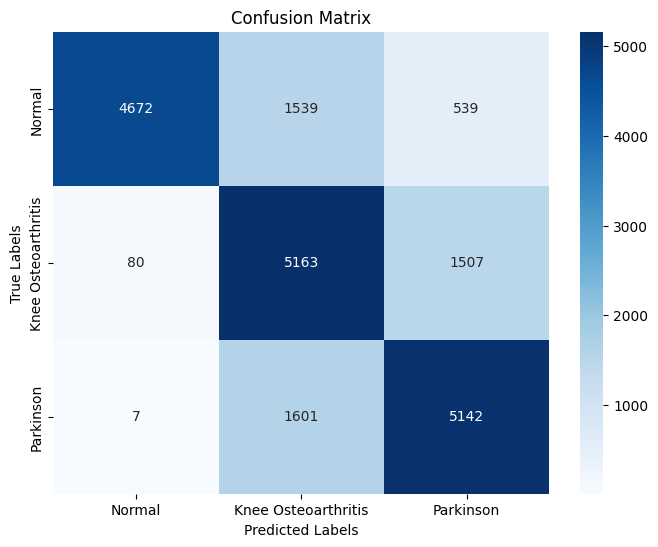

In [9]:
# Παράμετροι
data_folder = '/content/drive/MyDrive/project/train'
target = "disease"
test_size = 0.2
valid_size = 0.2
batch_size = 16
num_epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Διαχωρισμός δεδομένων
train_dataset, valid_dataset, test_dataset = train_valid_test_split(data_folder, target, test_size, valid_size)

# Δημιουργία DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Αρχικοποίηση μοντέλου
input_channels = 39
num_classes = 3
model = NeurologicalDiseaseModel(input_channels, num_classes).to(device)

# Εκπαίδευση και αξιολόγηση
best_model = train_and_evaluate(model,3, train_loader, valid_loader, test_loader, device, num_epochs, learning_rate)


___
##Προσθήκη επιπλέον κατηγοριών

####Αλλαγή υπερπαραμέτρων :
* epochs =20
*  learning rate = 0.001

✅ New Best Model Saved!
Epoch 1/20:
  Train Loss: 1.0933, Train Accuracy: 0.5193
  Valid Loss: 1.1449, Valid Accuracy: 0.5912
Epoch 2/20:
  Train Loss: 0.6743, Train Accuracy: 0.7181
  Valid Loss: 1.1835, Valid Accuracy: 0.6201
Epoch 3/20:
  Train Loss: 0.5138, Train Accuracy: 0.7950
  Valid Loss: 1.3214, Valid Accuracy: 0.6108
Epoch 4/20:
  Train Loss: 0.4063, Train Accuracy: 0.8391
  Valid Loss: 1.5231, Valid Accuracy: 0.5932
✅ New Best Model Saved!
Epoch 5/20:
  Train Loss: 0.3286, Train Accuracy: 0.8733
  Valid Loss: 1.6688, Valid Accuracy: 0.5765
Epoch 6/20:
  Train Loss: 0.2760, Train Accuracy: 0.8951
  Valid Loss: 1.7778, Valid Accuracy: 0.6192
✅ New Best Model Saved!
Epoch 7/20:
  Train Loss: 0.2356, Train Accuracy: 0.9126
  Valid Loss: 1.9719, Valid Accuracy: 0.5759
Epoch 8/20:
  Train Loss: 0.2147, Train Accuracy: 0.9209
  Valid Loss: 1.7600, Valid Accuracy: 0.6002
✅ New Best Model Saved!
Epoch 9/20:
  Train Loss: 0.1923, Train Accuracy: 0.9303
  Valid Loss: 2.0735, Valid Acc

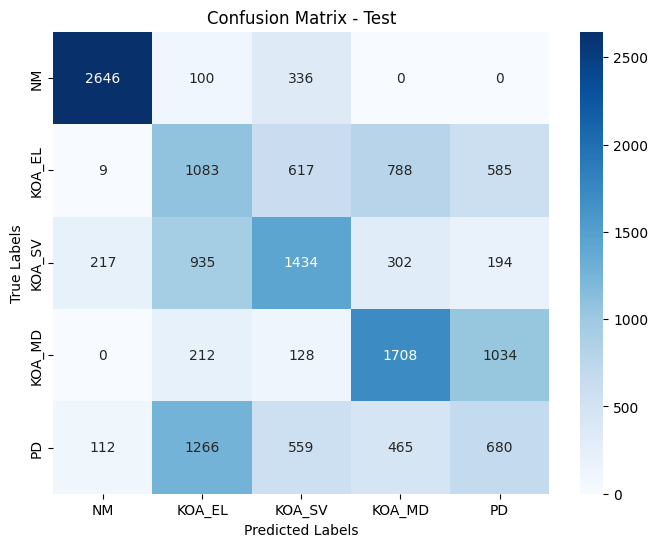

In [ ]:
# Παράμετροι
data_folder = '/content/drive/MyDrive/project/train'
target = "Disease_Level"
test_size = 0.2
valid_size = 0.2
batch_size = 32
num_epochs = 20
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Διαχωρισμός δεδομένων
train_dataset, valid_dataset, test_dataset = train_valid_test_split(data_folder, target, test_size, valid_size)

# Δημιουργία DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Αρχικοποίηση μοντέλου
input_channels = 39
num_classes = 5
model = NeurologicalDiseaseModel(input_channels, num_classes).to(device)

# Εκπαίδευση και αξιολόγηση
best_model = train_and_evaluate(model,5, train_loader, valid_loader, test_loader, device, num_epochs, learning_rate)